In [26]:
#Load the necessary libs:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import pyogrio
from shapely.geometry import Point
from shapely import wkt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import tree
from IPython.display import Image
import pydotplus

# To ignore some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Load the geodata file

In [27]:
gdf = pyogrio.read_dataframe('data/tl_2023_36_tract/tl_2023_36_tract.shx')

### Population in NYC Data by census tract

In [28]:
Cenpop = gpd.read_file('data/nyc_decennialcensusdata_2010_2020_change-core-geographies.csv')

In [29]:
Cenpop['GeoID'] = Cenpop['GeoID'].astype(str)

In [30]:
Cenpop = pd.merge(Cenpop, gdf[['GEOID', 'geometry']], left_on='GeoID', right_on='GEOID', how='left')

In [31]:
Cenpop = gpd.GeoDataFrame(Cenpop, geometry='geometry_y').set_crs("EPSG:4269", inplace=True)

In [32]:
Cenpop.head()

,Year,GeoType,Borough,GeoID,BCT2020,Name,CDType,NTAType,Pop1,Pop1P,...,Pop70t74P,Pop75t79,Pop75t79P,Pop80t84,Pop80t84P,Pop85pl,Pop85plP,geometry_x,GEOID,geometry_y
0,2020,CT2020,Bronx,36005000100,2000100,,,,"3,772",100.0,...,0.2,4,0.1,6,0.2,1,0.0,None,36005000100,"POLYGON ((-73.89772 40.79514, -73.89611 40.796..."
1,2020,CT2020,Bronx,36005000200,2000200,,,,"4,779",100.0,...,2.8,108,2.3,61,1.3,96,2.0,None,36005000200,"POLYGON ((-73.86648 40.80590, -73.86231 40.809..."
2,2020,CT2020,Bronx,36005000400,2000400,,,,"6,272",100.0,...,4.0,105,1.7,69,1.1,64,1.0,None,36005000400,"POLYGON ((-73.85960 40.81528, -73.85870 40.815..."
3,2020,CT2020,Bronx,36005001600,2001600,,,,"5,795",100.0,...,4.2,171,3.0,131,2.3,143,2.5,None,36005001600,"POLYGON ((-73.86246 40.81925, -73.86153 40.819..."
4,2020,CT2020,Bronx,36005001901,2001901,,,,"2,292",100.0,...,0.7,16,0.7,9,0.4,6,0.3,None,36005001901,"POLYGON ((-73.93180 40.80788, -73.93094 40.808..."


### Legally opperating businesses in NYC

In [33]:
legal_opperate = pd.read_csv('https://data.cityofnewyork.us/api/views/w7w3-xahh/rows.csv?date=20231207&accessType=DOWNLOAD')

/var/folders/qp/9y56mfxx3zq2c_cjbvf9xg_w0000gn/T/ipykernel_99189/1129729009.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  legal_opperate = pd.read_csv('https://data.cityofnewyork.us/api/views/w7w3-xahh/rows.csv?date=20231207&accessType=DOWNLOAD')


In [34]:
#drop na where longtitude and latitude are na.
legal_opperate = legal_opperate.dropna(subset=['Longitude', 'Latitude'])


In [35]:
geometry = [Point(xy) for xy in zip(legal_opperate.Longitude, legal_opperate.Latitude)]
legal_opperate = gpd.GeoDataFrame(legal_opperate, geometry=geometry)

legal_opperate.set_crs("EPSG:4269", inplace=True)
legal_opperate.head()

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location,geometry
18,0365714-DCA,Business,03/31/2005,Inactive,04/08/1997,Garage,THE GARDENS 75TH STREET OWNERS CORP.,NaN,3538,75TH ST,...,25.0,4029562,4012740020.0,QN28,289.0,"Vehicle Spaces: 85, Bicycle Spaces:",-73.891136,40.750745,"(40.75074488262595, -73.89113569640881)",POINT (-73.89114 40.75074)
19,1076184-DCA,Business,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",SUNRISE DELICATESSEN,2017,CHURCH AVE,...,40.0,3116556,3050810039.0,BK42,50801.0,NaN,-73.960737,40.650123,"(40.6501225946322, -73.96073707845565)",POINT (-73.96074 40.65012)
23,2061591-DCA,Business,12/31/2021,Inactive,11/25/2017,Laundries,SING WAH LAUNDROMAT INC.,NaN,6914,4TH AVE,...,43.0,3145701,3058720047.0,BK31,68.0,Laundry Type: Retail Laundry,-74.023621,40.634397,"(40.63439650603149, -74.02362065616948)",POINT (-74.02362 40.63440)
24,2009334-DCA,Business,05/23/2020,Inactive,06/09/2014,Sidewalk Cafe,DCB DELANCEY CORPORATION,SEL ROSE,1,DELANCEY ST,...,1.0,1005662,1004240012.0,MN27,18.0,Sidewalk Cafe Type: Regular Unenclosed/Small U...,-73.993820,40.720242,"(40.720241568328824, -73.99382027141543)",POINT (-73.99382 40.72024)
26,2038840-DCA,Business,07/31/2021,Inactive,06/09/2016,Secondhand Dealer - General,MD BROADWAY ELECTRONICS LLC,NaN,1888,JEROME AVE,...,14.0,2013962,2031790031.0,NaN,NaN,NaN,-73.906078,40.855206,"(40.85520587133494, -73.90607848934312)",POINT (-73.90608 40.85521)


### License application in NYC

In [36]:
license_appli = pd.read_csv('https://data.cityofnewyork.us/api/views/ptev-4hud/rows.csv?date=20231207&accessType=DOWNLOAD')

/var/folders/qp/9y56mfxx3zq2c_cjbvf9xg_w0000gn/T/ipykernel_99189/2915713197.py:1: DtypeWarning: Columns (20,24) have mixed types. Specify dtype option on import or set low_memory=False.
  license_appli = pd.read_csv('https://data.cityofnewyork.us/api/views/ptev-4hud/rows.csv?date=20231207&accessType=DOWNLOAD')


In [37]:
license_appli = license_appli.dropna(subset=['Longitude', 'Latitude'])

In [38]:
geometry = [Point(xy) for xy in zip(license_appli.Longitude, license_appli.Latitude)]
license_appli = gpd.GeoDataFrame(license_appli, geometry=geometry)

license_appli.set_crs("EPSG:4269", inplace=True)
license_appli.head()

,Application ID,License Number,License Type,Application or Renewal,Business Name,Status,Start Date,End Date,Temp Op Letter Issued,Temp Op Letter Expiration,...,Unit,Description,City,State,Zip,Contact Phone,Longitude,Latitude,Active Vehicles,geometry
0,1066-2017-RHIC,1294131-DCA,Business,Renewal,PEYKO TZENOV,Issued,01/09/2017,01/10/2017,NaN,NaN,...,NaN,NaN,BRONX,NY,10467,9178047161,-73.877091,40.876214,NaN,POINT (-73.87709 40.87621)
1,7066-2014-ASLS,2009515-DCA,Business,Application,7TH AVE GOURMET INC.,Issued,06/02/2014,06/13/2014,NaN,NaN,...,NaN,NaN,NEW YORK,NY,10011,718-783-3806,-73.975088,40.674997,NaN,POINT (-73.97509 40.67500)
2,1164-2019-RDPD,1472251-DCA,Business,Renewal,AMERICAN EAST PHARMACY INC.,Issued,01/09/2019,01/10/2019,NaN,NaN,...,NaN,NaN,NEW YORK,NY,10002,2129251900,-73.996169,40.714118,NaN,POINT (-73.99617 40.71412)
3,33701-2016-RELE,2025971-DCA,Business,Renewal,LUCAS ELECTRONICS INC,Issued,12/31/2016,01/10/2017,NaN,NaN,...,NaN,NaN,BROOKLYN,NY,11222,347-987-3235,-73.954098,40.729869,NaN,POINT (-73.95410 40.72987)
4,34278-2018-RELE,2047043-DCA,Business,Renewal,ELITE WIRELESS GROUP NY LLC,Issued,12/31/2018,01/08/2019,NaN,NaN,...,NaN,NaN,BROOKLYN,NY,11226,718-484-7746,-73.949327,40.650826,NaN,POINT (-73.94933 40.65083)


### NYC subway station data:

In [39]:
Stations = pd.read_csv( 'https://raw.githubusercontent.com/CUSP2021ADS/Data/main/NYCSubwayNodes.csv' , index_col=None, header=0 )

In [40]:
geometry = [Point(xy) for xy in zip(Stations.long, Stations.lat)]
Stations = gpd.GeoDataFrame(Stations, geometry=geometry)

Stations.set_crs("EPSG:4269", inplace=True)
Stations.head()

,name,id,boro,lat,long,lines,geometry
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,POINT (-73.95445 40.73135)
1,21 St,G24,Q,40.744065,-73.949724,G,POINT (-73.94972 40.74406)
2,Court Sq,G22,Q,40.746554,-73.943832,G,POINT (-73.94383 40.74655)
3,36 St,G20,Q,40.752039,-73.928781,M R,POINT (-73.92878 40.75204)
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,POINT (-73.93724 40.74897)


### NYC Bus Station data

In [41]:
bus_data = pd.read_csv('https://data.cityofnewyork.us/api/views/t4f2-8md7/rows.csv?accessType=DOWNLOAD')

In [42]:
bus_data['geometry'] = bus_data['the_geom'].apply(wkt.loads)

In [43]:
bus_data = gpd.GeoDataFrame(bus_data, geometry='geometry')
bus_data.set_crs("EPSG:4269", inplace=True)
bus_data.head()

,the_geom,BoroCode,BoroName,BoroCD,CounDist,AssemDist,StSenDist,CongDist,Shelter_ID,Corner,On_Street,Cross_Stre,Longitude,Latitude,NTAName,FEMAFldz,FEMAFldT,HrcEvac,geometry
0,POINT (-73.94874357365637 40.64085475597672),3,Brooklyn,317,45,42,21,9,BR02218,SW,AV D,NOSTRAND AV,-73.948745,40.640863,East Flatbush-Erasmus,X,AREA OF MINIMAL FLOOD HAZARD,5.0,POINT (-73.94874 40.64085)
1,POINT (-74.02283555116742 40.6292447605423),3,Brooklyn,310,43,46,26,11,BR02219,SW,5 AV,BAY RIDGE PKWY,-74.022837,40.629253,Bay Ridge,X,AREA OF MINIMAL FLOOD HAZARD,NaN,POINT (-74.02284 40.62924)
2,POINT (-73.92467258003798 40.67375874807616),3,Brooklyn,308,41,55,20,9,BR02220,SE,ST MARKS AV,BUFFALO AV,-73.924674,40.673767,Crown Heights (North),X,AREA OF MINIMAL FLOOD HAZARD,NaN,POINT (-73.92467 40.67376)
3,POINT (-73.9401345806071 40.578033768126936),3,Brooklyn,315,48,45,23,8,BR02221,SW,ORIENTAL BLVD,MACKENZIE ST,-73.940136,40.578042,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,X,AREA OF MINIMAL FLOOD HAZARD,1.0,POINT (-73.94013 40.57803)
4,POINT (-73.93991658060635 40.57805676808165),3,Brooklyn,315,48,45,23,8,BR02222,SW,ORIENTAL BLVD,MACKENZIE ST,-73.939918,40.578065,Sheepshead Bay-Manhattan Beach-Gerritsen Beach,X,AREA OF MINIMAL FLOOD HAZARD,1.0,POINT (-73.93992 40.57806)


### NYC parking lot 

In [44]:
parking_data = pd.read_csv('data/DOITT_PARKING_LOT_20240420.csv')

In [45]:
parking_data['geometry'] = parking_data['the_geom'].apply(wkt.loads)
parking_data = gpd.GeoDataFrame(parking_data, geometry='geometry')
parking_data.set_crs("EPSG:4269", inplace=True)
parking_data.head()

,the_geom,SOURCE_ID,FEAT_CODE,SUB_CODE,STATUS,SHAPE_Leng,SHAPE_Area,geometry
0,MULTIPOLYGON (((-73.97910559725612 40.69049642...,21500000001,5000,500000,Unchanged,778.318836,32676.073685,"MULTIPOLYGON (((-73.97911 40.69050, -73.97910 ..."
1,MULTIPOLYGON (((-73.97943374194773 40.69316130...,21500000002,5000,500000,Updated,3737.772791,108080.622252,"MULTIPOLYGON (((-73.97943 40.69316, -73.97944 ..."
2,MULTIPOLYGON (((-73.9832399249372 40.702812757...,21500000003,5000,500000,Unchanged,442.772495,5407.860486,"MULTIPOLYGON (((-73.98324 40.70281, -73.98325 ..."
3,MULTIPOLYGON (((-73.98189157977659 40.70310347...,21500000004,5000,500000,Unchanged,284.623893,4027.729151,"MULTIPOLYGON (((-73.98189 40.70310, -73.98190 ..."
4,MULTIPOLYGON (((-73.98594989444811 40.70232449...,21500000005,5000,500000,Unchanged,1567.687419,122903.007235,"MULTIPOLYGON (((-73.98595 40.70232, -73.98595 ..."


### Median income by census tract

In [46]:
median_income = pd.read_csv('data/censustract-medianhouseholdincome2022.csv')

In [47]:
median_income['Census Tract'] = median_income['Census Tract'].astype(str)

In [48]:
med_income = pd.merge(median_income, gdf[['GEOID', 'geometry']], left_on='Census Tract', right_on='GEOID', how='left')

In [49]:
gpd_med_income = gpd.GeoDataFrame(med_income, geometry='geometry')

In [50]:
gpd_med_income.head()

,short_name,long_name,Census Tract,2009-2013,2014-2018,GEOID,geometry
0,hh_inc_med_adj,Median household income (2022$),36005041900,43887.524204,36984.666450,36005041900,"POLYGON ((-73.88527 40.87923, -73.88466 40.879..."
1,hh_inc_med_adj,Median household income (2022$),36005042000,36089.108199,42552.994051,36005042000,"POLYGON ((-73.86229 40.89261, -73.86220 40.892..."
2,hh_inc_med_adj,Median household income (2022$),36005042100,61363.318016,39472.449695,36005042100,"POLYGON ((-73.88705 40.88436, -73.88686 40.884..."
3,hh_inc_med_adj,Median household income (2022$),36005042200,61962.267279,52862.277148,36005042200,"POLYGON ((-73.85852 40.89134, -73.85813 40.892..."
4,hh_inc_med_adj,Median household income (2022$),36005042300,40694.738215,42457.789589,36005042300,"POLYGON ((-73.87977 40.87712, -73.87972 40.877..."


#### Median Income w/ geometry

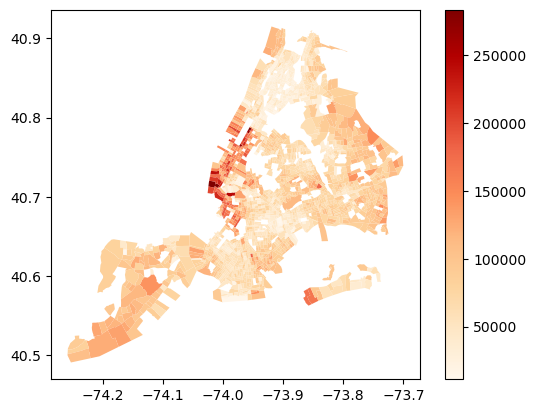

In [51]:
ax = gpd_med_income.plot(column='2014-2018', cmap='OrRd', legend=True)

# Show the plot
plt.show()

### join datasets: Legally opperating businesses in NYC & License application in NYC

In [52]:
Business = pd.merge(legal_opperate, license_appli, left_on='DCA License Number', right_on='License Number')

In [53]:
#Drop the unnessery Columns
drop = ['License Type_x','Business Name 2','Address Building','Secondary Address Street Name','Contact Phone Number','Address State','Borough Code','Community Board','Council District','BIN','BBL','NTA','Census Tract','Detail','Longitude_x','Latitude_x','Location','Application ID','License Number','License Type_y','Business Name_y','Application Category','Building Number','Street','Street 2','Unit Type','Unit','Description','City','State','Zip','Contact Phone','Longitude_y','Latitude_y','Active Vehicles','geometry_y']
Business_clean = Business.drop(drop, axis=1)

In [54]:
Business_clean.head()

,DCA License Number,License Expiration Date,License Status,License Creation Date,Industry,Business Name_x,Address Street Name,Address City,Address ZIP,Address Borough,geometry_x,Application or Renewal,Status,Start Date,End Date,Temp Op Letter Issued,Temp Op Letter Expiration,License Category
0,1076184-DCA,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",CHURCH AVE,BROOKLYN,11226,Brooklyn,POINT (-73.96074 40.65012),Renewal,Issued,12/03/2002,12/03/2002,NaN,NaN,Tobacco Retail Dealer
1,1076184-DCA,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",CHURCH AVE,BROOKLYN,11226,Brooklyn,POINT (-73.96074 40.65012),Application,Issued,04/02/2001,04/02/2001,NaN,NaN,Tobacco Retail Dealer
2,2061591-DCA,12/31/2021,Inactive,11/25/2017,Laundries,SING WAH LAUNDROMAT INC.,4TH AVE,BROOKLYN,11209,Brooklyn,POINT (-74.02362 40.63440),Renewal,Issued,11/27/2019,11/28/2019,NaN,NaN,Laundries
3,2061591-DCA,12/31/2021,Inactive,11/25/2017,Laundries,SING WAH LAUNDROMAT INC.,4TH AVE,BROOKLYN,11209,Brooklyn,POINT (-74.02362 40.63440),Application,Issued,11/20/2017,11/26/2017,NaN,NaN,Laundries
4,2009334-DCA,05/23/2020,Inactive,06/09/2014,Sidewalk Cafe,DCB DELANCEY CORPORATION,DELANCEY ST,NEW YORK,10002,Manhattan,POINT (-73.99382 40.72024),Renewal,Issued,12/14/2016,12/14/2016,NaN,NaN,Sidewalk Cafe


In [55]:
# NYC businesses status:
Business_clean['Status'].value_counts()

Issued       257428
Denied         2098
Pending        1052
Withdrawn       182
Name: Status, dtype: int64

##### Desciding the clustering factors by  
0: Denied or Withdrawn

1: Issued

In [56]:
Business_clean.loc[Business_clean['Status'] == 'Denied', 'Status'] = 0
Business_clean.loc[Business_clean['Status'] == 'Withdrawn', 'Status'] = 0
Business_clean.loc[Business_clean['Status'] == 'Issued', 'Status'] = 1


In [57]:
Business_clean.head()

,DCA License Number,License Expiration Date,License Status,License Creation Date,Industry,Business Name_x,Address Street Name,Address City,Address ZIP,Address Borough,geometry_x,Application or Renewal,Status,Start Date,End Date,Temp Op Letter Issued,Temp Op Letter Expiration,License Category
0,1076184-DCA,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",CHURCH AVE,BROOKLYN,11226,Brooklyn,POINT (-73.96074 40.65012),Renewal,1,12/03/2002,12/03/2002,NaN,NaN,Tobacco Retail Dealer
1,1076184-DCA,12/31/2004,Inactive,04/02/2001,Tobacco Retail Dealer,"JALIL, MOHAMMED ABDUL",CHURCH AVE,BROOKLYN,11226,Brooklyn,POINT (-73.96074 40.65012),Application,1,04/02/2001,04/02/2001,NaN,NaN,Tobacco Retail Dealer
2,2061591-DCA,12/31/2021,Inactive,11/25/2017,Laundries,SING WAH LAUNDROMAT INC.,4TH AVE,BROOKLYN,11209,Brooklyn,POINT (-74.02362 40.63440),Renewal,1,11/27/2019,11/28/2019,NaN,NaN,Laundries
3,2061591-DCA,12/31/2021,Inactive,11/25/2017,Laundries,SING WAH LAUNDROMAT INC.,4TH AVE,BROOKLYN,11209,Brooklyn,POINT (-74.02362 40.63440),Application,1,11/20/2017,11/26/2017,NaN,NaN,Laundries
4,2009334-DCA,05/23/2020,Inactive,06/09/2014,Sidewalk Cafe,DCB DELANCEY CORPORATION,DELANCEY ST,NEW YORK,10002,Manhattan,POINT (-73.99382 40.72024),Renewal,1,12/14/2016,12/14/2016,NaN,NaN,Sidewalk Cafe


In [58]:
data_train,data_test = train_test_split(Business_clean, test_size=0.33, random_state=99)

In [59]:
# Convert the Pandas Business_clean to geopandas
Business_clean=gpd.GeoDataFrame(Business_clean, geometry='geometry_x')
Business_clean.set_crs("EPSG:4269", inplace=True)
# sjoin the population to location of each Business based on geometry 
Business_pop = gpd.sjoin(Business_clean, Cenpop, how='left', op='intersects')
columns_to_drop = ['Name', 'CDType', 'NTAType','Pop1P', 'Male', 'Male P', 'Fem', 'FemP', 'PopU5', 'PopU5P', 'Pop5t9', 'Pop5t9P', 'Pop10t14', 'Pop10t14P', 'Pop15t19', 'Pop15t19P', 'Pop20t24', 'Pop20t24P', 'Pop25t29', 'Pop25t29P', 'Pop30t34', 'Pop30t34P', 'Pop35t39', 'Pop35t39P', 'Pop40t44', 'Pop40t44P', 'Pop45t49', 'Pop45t49P', 'Pop50t54', 'Pop50t54P', 'Pop55t59', 'Pop55t59P', 'Pop60t64', 'Pop60t64P', 'Pop65t69', 'Pop65t69P', 'Pop70t74', 'Pop70t74P', 'Pop75t79', 'Pop75t79P', 'Pop80t84', 'Pop80t84P', 'Pop85pl', 'Pop85plP']
Business_pop = Business_pop.drop(columns=columns_to_drop)

In [60]:

Business_pop=gpd.GeoDataFrame(Business_pop, geometry='geometry_x_left')
Business_pop.set_crs("EPSG:4269", inplace=True)

Business_pop=Business_pop.drop(columns=['index_right','GEOID'])

In [61]:
#sjoin the accessibilities(bus, subway, and parking lots) to location of each Business based on geometry 
bus_geo = gpd.sjoin(bus_data,Cenpop,how = 'left',op = 'intersects')
subway_geo = gpd.sjoin(Stations,Cenpop,how = 'left',op = 'intersects')

In [62]:
def add_geoID(data):
    drop_column = ['index_right', 'Year', 'GeoType','Borough','BCT2020', 'Name', 'CDType', 'NTAType','Pop5t9P', 'Pop10t14', 'Pop10t14P', 'Pop15t19', 'Pop15t19P', 'Pop20t24',
       'Pop20t24P', 'Pop25t29', 'Pop25t29P', 'Pop30t34', 'Pop30t34P',
       'Pop35t39', 'Pop35t39P', 'Pop40t44', 'Pop40t44P', 'Pop45t49',
       'Pop45t49P', 'Pop50t54', 'Pop50t54P', 'Pop55t59', 'Pop55t59P',
       'Pop60t64', 'Pop60t64P', 'Pop65t69', 'Pop65t69P', 'Pop70t74',
       'Pop70t74P', 'Pop75t79', 'Pop75t79P', 'Pop80t84', 'Pop80t84P',
       'Pop85pl', 'Pop85plP','Pop1P', 'Male', 'Male P', 'Fem', 'FemP', 'PopU5', 'PopU5P', 'Pop5t9','GEOID']
    data = data.drop(columns = drop_column)
    return data

In [63]:
# add geo information to the tables of accessibilities
bus_geo = add_geoID(bus_geo)
subway_geo = add_geoID(subway_geo)


In [64]:
parking_geo = gpd.sjoin(parking_data,Cenpop,how = 'left',op = 'intersects')

In [65]:
parking_geo = add_geoID(parking_geo)

In [66]:
def group_data(data):
    data = data.groupby(by = 'GeoID')['Pop1'].count()
    return data

#### Count the amount of each type of accessibility in each Census tract area

In [67]:
parking_count = pd.DataFrame(group_data(parking_geo))
parking_count = parking_count.rename(columns={'Pop1':'Parking_counts'})

In [68]:
bus_count = pd.DataFrame(group_data(bus_geo))
bus_count = bus_count.rename(columns={'Pop1':'Bus_station_counts'})

In [69]:
subway_count = pd.DataFrame(group_data(subway_geo))
subway_count = subway_count.rename(columns={'Pop1':'Subway_station_counts'})

#### Add the counted data to the table used for the models

In [70]:
business_data2 = pd.merge(Business_pop,bus_count,left_on='GeoID',right_on='GeoID',how = 'left')

In [71]:
business_data2 = pd.merge(business_data2,subway_count,left_on='GeoID',right_on='GeoID',how = 'left')
business_data2 = pd.merge(business_data2,parking_count,left_on='GeoID',right_on='GeoID',how = 'left')

In [72]:
business_data2 = business_data2.loc[business_data2['Status'] != 'Pending']

In [74]:
# Final data for models(data_model.csv = business_data2.dropna())
Business_model_data = pd.read_csv('data/data_model.csv')

In [75]:
Business_model_data.head()

,Status,DCA License Number,License Creation Date,Business Name_x,Industry,Pop1,2014-2018,Bus_station_counts,Subway_station_counts,Parking_counts,GeoID,geometry_x_left
0,1,1076184-DCA,04/02/2001,"JALIL, MOHAMMED ABDUL",Tobacco Retail Dealer,"4,311",49812.334226,0.0,0.0,0.0,36047050801,POINT (-73.96073707845565 40.6501225946322)
1,1,1076184-DCA,04/02/2001,"JALIL, MOHAMMED ABDUL",Tobacco Retail Dealer,"4,311",49812.334226,0.0,0.0,0.0,36047050801,POINT (-73.96073707845565 40.6501225946322)
2,1,2061591-DCA,11/25/2017,SING WAH LAUNDROMAT INC.,Laundries,"5,491",55429.397444,3.0,1.0,5.0,36047006800,POINT (-74.02362065616948 40.63439650603149)
3,1,2061591-DCA,11/25/2017,SING WAH LAUNDROMAT INC.,Laundries,"5,491",55429.397444,3.0,1.0,5.0,36047006800,POINT (-74.02362065616948 40.63439650603149)
4,1,2009334-DCA,06/09/2014,DCB DELANCEY CORPORATION,Sidewalk Cafe,"7,934",57572.631210,2.0,4.0,4.0,36061001800,POINT (-73.99382027141543 40.720241568328824)


#### Want to find out the count of each type of industry in each Census Tract Area, AKA. Competitor for each industry

In [78]:
industry_type_geo = Business_model_data.groupby(['GeoID','Industry'])['Business Name_x'].count()

In [79]:
industry_type_geo = pd.DataFrame(industry_type_geo)

industry_type_geo = industry_type_geo.rename(columns={'Business Name_x':'Competitor_count'})
industry_type_geo

Competitor_count
GeoID       Industry                                        
0           Amusement Device Permanent                     9
            Amusement Device Portable                      1
            Cabaret                                        8
            Catering Establishment                         1
            Electronic & Appliance Service                 6
...                                                      ...
36085032300 Home Improvement Contractor                   20
            Secondhand Dealer - General                    4
            Stoop Line Stand                               5
            Tobacco Retail Dealer                         31
            Tow Truck Company                              4

[20057 rows x 1 columns]

In [81]:
# Merge the competitor count the final data
Business_model_data2 = pd.merge(Business_model_data,industry_type_geo,on=['GeoID','Industry'],how='left')

In [82]:
Business_model_data2['Pop1'] = Business_model_data2['Pop1'].str.replace(',', '').astype(int)
Business_model_data2.head()

,Status,DCA License Number,License Creation Date,Business Name_x,Industry,Pop1,2014-2018,Bus_station_counts,Subway_station_counts,Parking_counts,GeoID,geometry_x_left,Competitor_count
0,1,1076184-DCA,04/02/2001,"JALIL, MOHAMMED ABDUL",Tobacco Retail Dealer,4311,49812.334226,0.0,0.0,0.0,36047050801,POINT (-73.96073707845565 40.6501225946322),44
1,1,1076184-DCA,04/02/2001,"JALIL, MOHAMMED ABDUL",Tobacco Retail Dealer,4311,49812.334226,0.0,0.0,0.0,36047050801,POINT (-73.96073707845565 40.6501225946322),44
2,1,2061591-DCA,11/25/2017,SING WAH LAUNDROMAT INC.,Laundries,5491,55429.397444,3.0,1.0,5.0,36047006800,POINT (-74.02362065616948 40.63439650603149),17
3,1,2061591-DCA,11/25/2017,SING WAH LAUNDROMAT INC.,Laundries,5491,55429.397444,3.0,1.0,5.0,36047006800,POINT (-74.02362065616948 40.63439650603149),17
4,1,2009334-DCA,06/09/2014,DCB DELANCEY CORPORATION,Sidewalk Cafe,7934,57572.631210,2.0,4.0,4.0,36061001800,POINT (-73.99382027141543 40.720241568328824),17


# Random Forest:

              precision    recall  f1-score   support

           0       0.29      0.01      0.02       467
           1       0.99      1.00      1.00     51475

    accuracy                           0.99     51942
   macro avg       0.64      0.51      0.51     51942
weighted avg       0.98      0.99      0.99     51942

Accuracy: 0.990835932386123
Feature Importances: {'Industry_Amusement Arcade': 0.0006465627200203917, 'Industry_Amusement Device Permanent': 0.0019831825408629096, 'Industry_Amusement Device Portable': 0.005111521673240812, 'Industry_Amusement Device Temporary': 0.00019124685606957897, 'Industry_Auction House Premises': 0.0005790711095730454, 'Industry_Bingo Game Operator': 5.1928048666192077e-05, 'Industry_Booting Company': 1.600006418993928e-05, 'Industry_Cabaret': 0.004249490969778324, 'Industry_Car Wash': 0.001735392193395613, 'Industry_Catering Establishment': 0.00531915479467562, 'Industry_Commercial Lessor': 1.4983101253687784e-05, 'Industry_Construction Lab

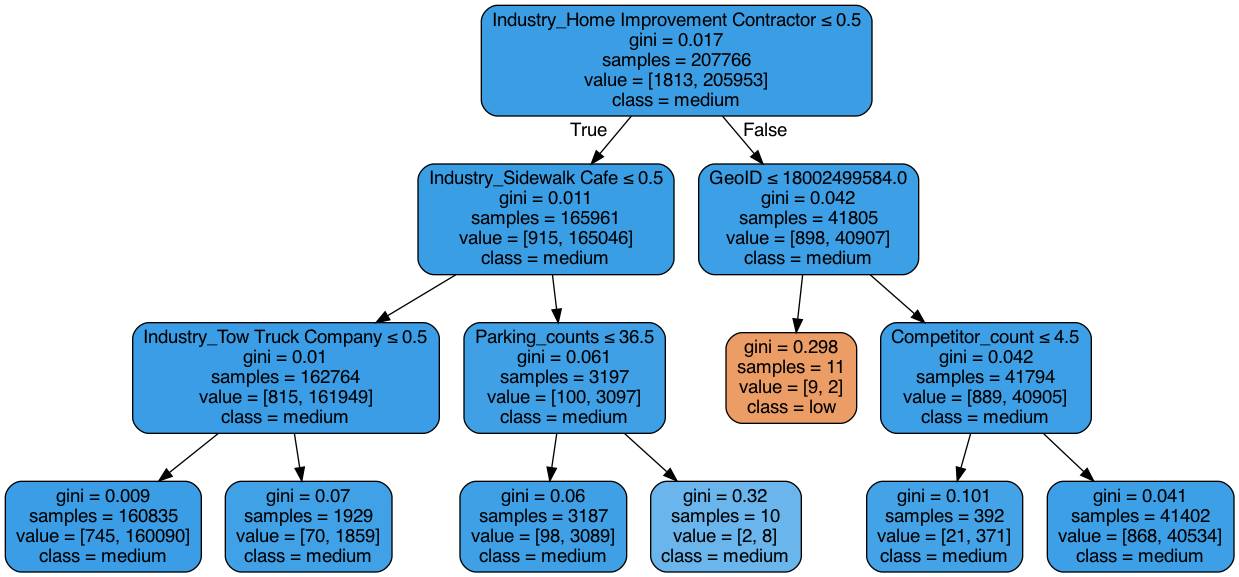

In [84]:
# Define the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('industry', OneHotEncoder(), ['Industry'])
    ],
    remainder='passthrough'
)

# Drop unnecessary columns and define target variable
X = Business_model_data2.drop(['Status', 'DCA License Number', 'License Creation Date', 'Business Name_x', 'geometry_x_left'], axis=1)
y = Business_model_data2['Status']

# Apply the column transformer to the features
X_transformed = column_transformer.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Build Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=50)
rf.fit(X_train, y_train)

# Evaluate the model
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Feature Importance
importances = rf.feature_importances_
# Adjust feature names to include transformed ones
transformed_features = column_transformer.named_transformers_['industry'].get_feature_names_out()
all_features = list(transformed_features) + [col for col in X.columns if col != 'Industry']
feature_importance_dict = {name: importance for name, importance in zip(all_features, importances)}
print("Feature Importances:", feature_importance_dict)

# Decision Tree Visualization
# Train a decision tree for visualization purposes
dt = tree.DecisionTreeClassifier(max_depth=3)  # Limited depth for better visualization
dt.fit(X_train, y_train)

# Export as dot file
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=all_features,  
                                class_names=['low','medium','high','awful'],
                                filled=True, rounded=True,  
                                special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


#### overall, the highest chance to survive as a business in NYC including the industry type has shown on graph above

              precision    recall  f1-score   support

           0       0.20      0.01      0.01       461
           1       0.99      1.00      1.00     51481

    accuracy                           0.99     51942
   macro avg       0.60      0.50      0.50     51942
weighted avg       0.98      0.99      0.99     51942

Accuracy: 0.9909514458434407
Feature Importances: {'Pop1': 0.20581816932100835, '2014-2018': 0.11010481174361292, 'Bus_station_counts': 0.03145458744602879, 'Subway_station_counts': 0.013574170564773504, 'Parking_counts': 0.060482742875826875, 'GEOID': 0.07712331638616717, 'Competitor_count': 0.5014422016625825}


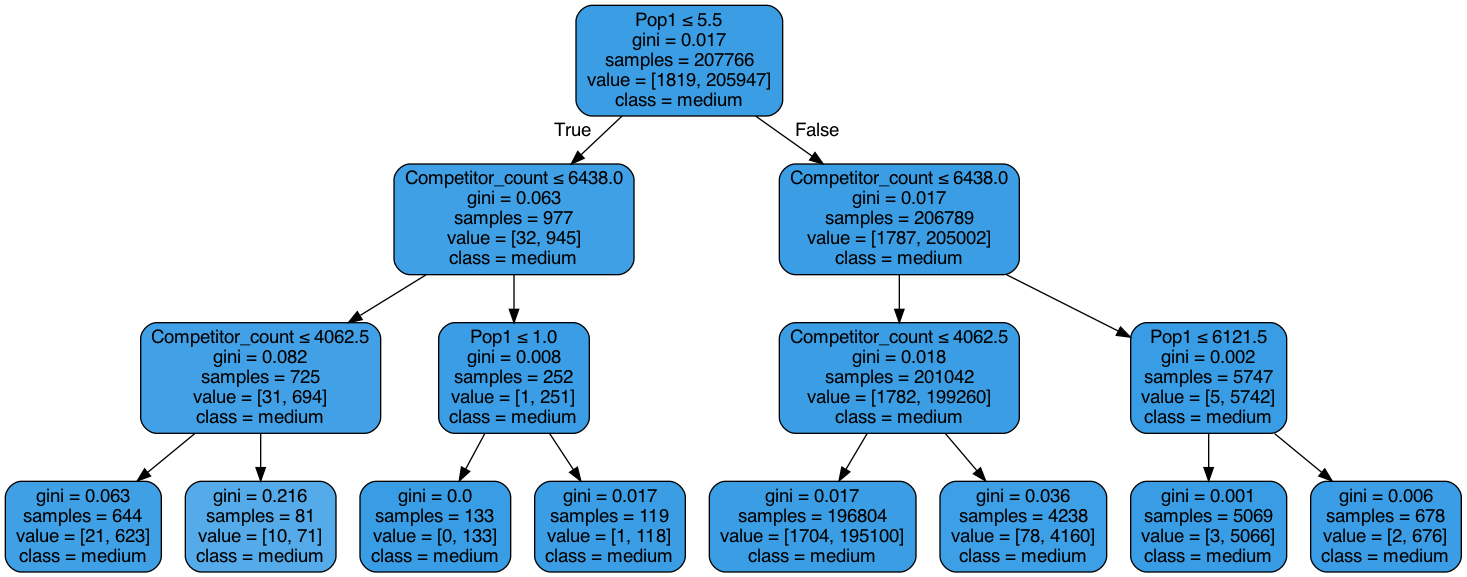

In [ ]:
X = Business_model_data2.drop(['Status', 'DCA License Number', 'License Creation Date', 'Business Name_x', 'geometry_x', 'Industry'], axis=1)
y = Business_model_data2['Status']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=50)
rf.fit(X_train, y_train)

# Evaluate the model
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Feature Importance
importances = rf.feature_importances_
all_features = X.columns
feature_importance_dict = {name: importance for name, importance in zip(all_features, importances)}
print("Feature Importances:", feature_importance_dict)

# Decision Tree Visualization
# Train a decision tree for visualization purposes
dt = tree.DecisionTreeClassifier(max_depth=3)  # Limited depth for better visualization
dt.fit(X_train, y_train)

# Export as dot file
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=all_features,  
                                class_names=['low','medium','high','awful'],  # Modify based on your classes
                                filled=True, rounded=True,  
                                special_characters=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### The above is overall factors which affact a business's surival rate in NYC